# Section 1: Env Setup
- Load data in tar file
- Mount Google Drive
- pip upgrade matplotlib dependencies
- Imports

In [1]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [5]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
# ! pip install --upgrade matplotlib # ONLY run this cell upon intially opening the notebook
# ! pip install fiftyone
! pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# ! wget https://www.mydrive.ch/shares/39258/39d0eaefc4dc611048ec970f886bad8d/download/420939224-1629955498/mvtec_screws_v1.0.tar.gz

--2022-12-15 17:25:40--  https://www.mydrive.ch/shares/39258/39d0eaefc4dc611048ec970f886bad8d/download/420939224-1629955498/mvtec_screws_v1.0.tar.gz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1361662840 (1.3G) [application/gzip]
Saving to: ‘mvtec_screws_v1.0.tar.gz’

mvtec_screws_v1.0.t 100%[===================>]   1.27G  15.1MB/s    in 90s     

2022-12-15 17:27:11 (14.5 MB/s) - ‘mvtec_screws_v1.0.tar.gz’ saved [1361662840/1361662840]



In [3]:
# ! tar -xf mvtec_screws_v1.0.tar.gz

In [2]:
import os
import json
from pathlib import Path
import pprint as pp
from glob import glob, iglob
from PIL import Image, ImageFilter, ImageDraw
from typing import List, Union, Tuple, BinaryIO

import pickle
import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory

from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import fiftyone as fo


In [3]:
#@title
pp.PrettyPrinter(indent=4)

In [3]:
data_img_path = Path('/content/data/images')
data_ann_path = Path('/content/data/mvtec_screws.json')
coco = COCO(data_ann_path)
img_ids = coco.getImgIds()
imgs = coco.loadImgs(img_ids[-3:])

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


## Configure Color Picker

In [4]:
COLORS = list(mcolors.TABLEAU_COLORS.keys())
def a_color(colors:list=COLORS):
  return np.random.choice(colors)


## Define Draw Bounding Box

In [5]:
def draw_box(data:dict, axis:plt.Axes):
  for entry in data: 
    row, col, width, height, phi = entry['bbox']
    angle = (180/np.pi) * -phi
    x = col - width/2
    y = row - height/2
    bbox = axis.add_patch(
        Rectangle((x,y), 
                  width,
                  height,
                  angle,
                  rotation_point='center',
                  edgecolor='green',
                  facecolor=a_color(),
                  linewidth=4,
                  alpha=.3))
  return axis

## Image with Bbox Annotation

<ipython-input-5-c9dfafb25268>:8: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Rectangle((x,y),


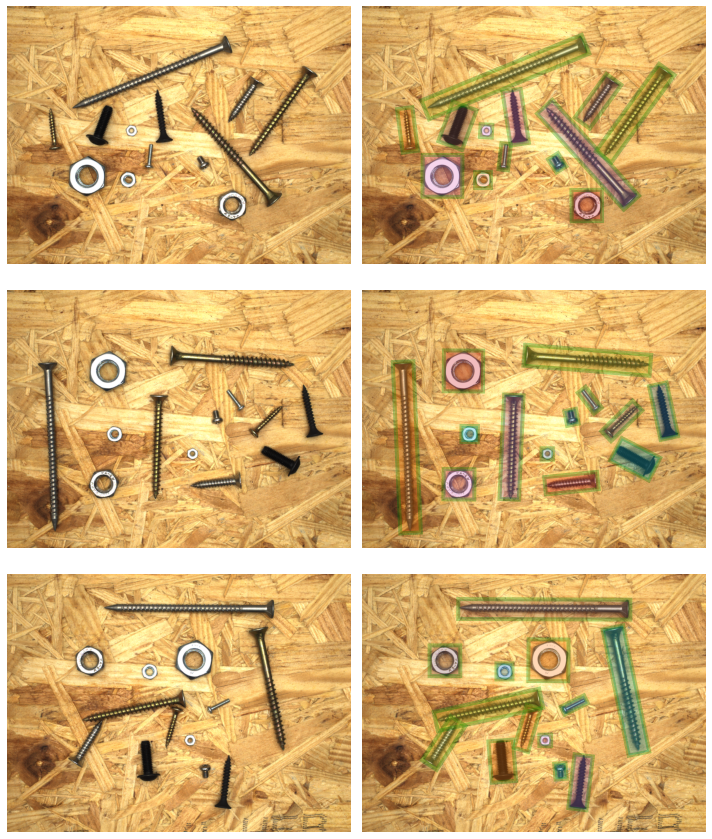

In [6]:
fig, ax = plt.subplots(len(imgs), 2, figsize=(10, 12))
for img, ax_n, in zip(imgs, ax):
  ann_id = coco.getAnnIds([img['id']])
  ann_data = coco.loadAnns(ann_id)
  i_n = Image.open(f"/content/data/images/{img['file_name']}")
  ax_n[0].imshow(i_n)
  ax_n[0].axis('off')
  ax_n[1].imshow(i_n)
  ax_n[1] = draw_box(ann_data, ax_n[1])
  ax_n[1].axis('off')
fig.tight_layout()
plt.show();

# Create Train and Test Labels


#### Helper Functions For Making Masks

In [10]:
def circle(radius, center_point, thickness:int=5):
  circ = round(radius**2 * np.pi)
  circle = []
  c_x, c_y = center_point
  for line in range(thickness):
    radius += line
    for pixel in range(circ):
      x, y = c_x + radius*np.cos(pixel * (2*np.pi)/circ),c_y + radius*np.sin(pixel * (2*np.pi)/circ) 
      circle.append((x, y))
  return circle
  
def rot_point(vector, center, phi):
  x, y = vector
  i, j = center
  vector = np.array([x-i, y-j], dtype=np.float32)
  id = np.asarray([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]], 
                  dtype=np.float32)
  x, y = np.matmul(id, vector)
  return np.array([x+i, y+j], dtype=np.float32)

def rot_box(box_edges:np.ndarray, center, phi):
  for i, vec in enumerate(box_edges):
    vec = rot_point(vec, phi)
    box_edges[i] = vec + center
    
  return box_edges

## Define Mask Making Function

In [38]:
def make_mask(data:dict, size:tuple=(None, None), save_mask:bool=False, file_name:str=None):
  """
  Function takes an image shape and a dictionary that defines a bounding box and
  returns a numpy array version of the image mask.
  """
  mask =Image.new("RGB", tuple(reversed(size)), color='black')
  draw = ImageDraw.Draw(mask, "RGB")
  colors = ['red', 'blue', 'green', 'purple']
  pick = np.random.choice
  count = 0
  for entry in data: 
    # grab bbox info
    row, col, width, height, phi = entry['bbox']
    
    # define center point of bbox
    center = np.array([col, row])
    # -pi to pi -> 0 to 2*pi 
    phi = phi + np.pi

    # initial bounds
    y0, y1 = row-height/2, row+height/2
    x0, x1 = col-width/2, col+width/2
    
    # corner points
    p0, p1, p2, p3 = (x0, y0), (x0, y1), (x1, y1), (x1, y0)

    # rotation
    rx0, ry0 = rot_point(p0, center, -phi)
    rx1, ry1 = rot_point(p1, center, -phi)
    rx2, ry2 = rot_point(p2, center, -phi)
    rx3, ry3 = rot_point(p3, center, -phi)

    # rotated corners
    rp0 = (rx0, ry0)
    rp1 = (rx1, ry1)
    rp2 = (rx2, ry2)
    rp3 = (rx3, ry3)
    
    # draw mask shapes
    draw.polygon([rp0, rp1, rp2, rp3], fill='#00F')
    # draw.polygon(circle(15, center), fill='#0F0')
  
  if save_mask:    
    mask.save(f"/content/gdrive/MyDrive/colab_output/bbox_mask/{file_name}", format='png')
  
  return np.asarray(mask, dtype=np.float32)

## Make the Masks

In [39]:
img_set = coco.loadImgs(img_ids)
# fig, axs = plt.subplots(len(img_set[5:]), 2, figsize=(10, 20))
for img in img_set:

  arr_img = np.asarray(
                  Image.open(f"/content/data/images/{img['file_name']}"),
                  dtype=np.float32)

  box_data = coco.loadAnns(coco.getAnnIds(img['id']))
  # mask = 
  make_mask(box_data, size=arr_img.shape[:-1], save_mask=True, file_name=img['file_name'])
  
#   mask = mask / 255
#   arr_img = arr_img / 255

#   ax[0].imshow(arr_img[:,:,:])
#   ax[0].axis('off')
#   ax[1].imshow(arr_img[:,:,:])
#   ax[1].imshow(mask, cmap='gray', alpha=.9)
#   ax[1].axis('off')
#   fig.tight_layout()

# plt.show()

# Baseline Model Definition

## Layer Definition

### Convolution Block Definition

In [ ]:
def conv2d_block(x, filters, kernel_size=3, reps:int=2, pooling:bool=False, **kwargs):
  residual = x
  options = {}
  if kwargs:
    options.update(**kwargs)
  for rep in range(reps):
    if not rep:
      options.update({'strides': 2})
    else:
      options['strides'] = 1
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, kernel_size, padding="same", use_bias=False, **options)(x)
  
  if pooling:
    x = layers.MaxPooling2D(kernel_size, strides=2, padding="same")(x)
    # residual = layers.Conv2D(filters, 1, strides=2)(residual)
  # elif filters != residual.shape[-1]:
  #   residual = layers.Conv2D(filters, 1)(residual)
  
  # x = layers.add([x, residual])
  return x

### Conv-Transpose (deconvolution) Layer Block Definition

In [ ]:
def conv2d_T_block(x, filters, kernel_size=3, reps:int=2, **kwargs):
  residual = x
  options = {'strides': 2}
  if kwargs:
    options.update(**kwargs)
  for rep in range(reps):
    if not rep:
      options.update({'strides': 2})
    else:
      options['strides'] = 1
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, kernel_size, padding="same", use_bias=False, **options)(x)
  
  # residual = layers.Conv2D(filters, 1)(residual)
  
  # x = layers.add([x, residual])
  return x

## Model Definition

In [ ]:
def get_model(input_shape, filter_blocks:List, rescaling:bool=False, **kwargs):
  inputs = tf.keras.Input(shape=input_shape)
  if rescaling:
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filter_blocks[0], kernel_size=5, padding='same', use_bias=False)(x)
  else:
    x = layers.Conv2D(filter_blocks[0], kernel_size=5, padding='same', use_bias=False)(inputs)
  
  for block in filter_blocks:
    x = conv2d_block(x, block, pooling=True, **kwargs)
  
  # r_filter_blocks = reversed(filter_blocks)
  # for t_block in r_filter_blocks:
  #   x = conv2d_T_block(x, t_block, **kwargs)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

  model = tf.keras.Model(inputs, outputs)
  return model

## Data Generator